# MtsCID Tutorial for Anomaly Detection
This notebook demonstrates how to use MtsCID for time series anomaly detection

## 1. Packages import and prepare arguments

In [1]:
import os
import time

import numpy as np
import torch
from sklearn.metrics import precision_recall_fscore_support
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from tsadlib.metrics.adjustment import point_adjustment

from tsadlib.configs.constants import PROJECT_ROOT
from tsadlib.configs.log_config import logger
from tsadlib.configs.type import ConfigType
from tsadlib.data_provider.data_factory import data_provider
from tsadlib.metrics.threshold import percentile_threshold
from tsadlib.models.MtsCID import MtsCID
from tsadlib.utils.loss import EntropyLoss, GatheringLoss, harmonic_loss_compute
from tsadlib.utils.lr_decay import PolynomialDecayLR
from tsadlib.utils.traning_stoper import OneEarlyStopping

# Set up device for computation (CUDA GPU, Apple M1/M2 GPU, or CPU)
if torch.cuda.is_available():
    device = 'cuda:0'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

logger.info(f'use device: {device}')
device = torch.device(device)

# Define paths for dataset and model checkpoints
# DATASET_ROOT = 'E:\\liuzhenzhou\\datasets'
# DATASET_ROOT = '/Users/liuzhenzhou/Documents/backup/datasets/anomaly_detection/npy'
DATASET_ROOT = '/home/lzz/Desktop/datasets/anomaly_datasets'
DATASET_TYPE = 'MSL'  # Mars Science Laboratory dataset
MODEL = 'MtsCID'
CHECKPOINTS = os.path.join(PROJECT_ROOT, 'checkpoints', MODEL)

writer = SummaryWriter(os.path.join(PROJECT_ROOT, 'runs', MODEL).__str__())

# Configure TimesNet hyperparameters and training settings
args = ConfigType(**{
    'model': MODEL,
    'mode': 'train',
    'dataset_root_path': os.path.join(DATASET_ROOT, DATASET_TYPE),
    'window_size': 100,
    'batch_size': 64,
    'd_model': 55,
    'encoder_layers': 1,
    'input_channels': 55,
    'output_channels': 55,
    'dropout': 0.1,
    'hyper_parameter_lambda': 1.0,
    'anomaly_ratio': 1
})

# Load training and testing data
train_loader, validate_loader, test_loader = data_provider(args, split_way='train_validate_split')

2025-04-03 21:37:18.525 | __main__:<module>:30 | INFO: use device: cuda:0


## 2. Model definition and training

In [2]:
# Initialize model and training components
model = MtsCID(args).to(device)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.learning_rate,
                              weight_decay=args.weight_decay)
scheduler = PolynomialDecayLR(optimizer, warmup_steps=args.warmup_epoch * args.batch_size,
                              total_steps=args.num_epochs * args.batch_size, lr=args.learning_rate,
                              end_lr=args.end_learning_rate, power=1.0)
criterion = nn.MSELoss(reduction='none')
entropy_criterion = EntropyLoss()
early_stopping = OneEarlyStopping(args.patience, CHECKPOINTS, DATASET_TYPE)
train_steps = len(train_loader)
logger.info('The training phase starts')

for epoch in range(args.num_epochs):
    model.train()
    train_losses = []
    reconstruct_losses = []
    entropy_losses = []
    validate_losses = []
    iter_count = 0
    epoch_time = time.time()

    model.train()
    for i, (x_data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1} / {args.num_epochs}')):
        iter_count += 1
        optimizer.zero_grad()
        x_data = x_data.float().to(device)

        # Forward pass
        output_dict = model(x_data)
        output, attention = output_dict['output'], output_dict['attention']
        reconstruct_loss = criterion(output, x_data).mean()
        entropy_loss = entropy_criterion(attention)
        loss = reconstruct_loss + entropy_loss * args.hyper_parameter_lambda

        if (i + 1) % 100 == 0:
            writer.add_scalar('Loss/Train', loss.item(), epoch * train_steps + i)
            writer.add_scalar('Loss/Reconstruct', reconstruct_loss.item(), epoch * train_steps + i)
            writer.add_scalar('Loss/Entropy', entropy_loss.item(), epoch * train_steps + i)

        # Backward pass
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        reconstruct_losses.append(reconstruct_loss.item())
        entropy_losses.append(entropy_loss)

    model.eval()
    with torch.no_grad():
        for i, (x_data, _) in enumerate(validate_loader):
            x_data = x_data.float().to(device)
            # Forward pass
            output_dict = model(x_data)
            output, attention = output_dict['output'], output_dict['attention']
            reconstruct_loss = criterion(output, x_data).mean()
            entropy_loss = entropy_criterion(attention)
            loss = reconstruct_loss + args.hyper_parameter_lambda * entropy_loss
            validate_losses.append(loss.item())

    train_avg_loss = np.average(train_losses)
    validate_avg_loss = np.average(validate_losses)
    logger.info("Epoch: {:>2} cost time: {:<10.4f}s, train loss: {:<.7f}, validate loss: {:<.7f}", epoch + 1,
                time.time() - epoch_time, train_avg_loss, validate_avg_loss)

    writer.add_scalars("Loss", {"Train": train_avg_loss, "Validation": validate_avg_loss}, epoch)

    # Early stopping check
    early_stopping(validate_avg_loss, model)
    if early_stopping.early_stop:
        logger.warning("Early stopping triggered")
        break

/home/lzz/anaconda3/envs/python313/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


2025-04-03 21:37:19.733 | __main__:<module>:12 | INFO: The training phase starts


Epoch 1 / 10: 100%|██████████| 7/7 [00:00<00:00, 11.68it/s]


2025-04-03 21:37:20.369 | __main__:<module>:62 | INFO: Epoch:  1 cost time: 0.6343    s, train loss: 0.8758674, validate loss: 0.8413286
2025-04-03 21:37:20.372 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (inf --> 0.841329).  Saving model ...


Epoch 2 / 10: 100%|██████████| 7/7 [00:00<00:00, 31.57it/s]


2025-04-03 21:37:20.626 | __main__:<module>:62 | INFO: Epoch:  2 cost time: 0.2463    s, train loss: 0.8256738, validate loss: 0.7142475
2025-04-03 21:37:20.626 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.841329 --> 0.714248).  Saving model ...


Epoch 3 / 10: 100%|██████████| 7/7 [00:00<00:00, 26.39it/s]


2025-04-03 21:37:20.923 | __main__:<module>:62 | INFO: Epoch:  3 cost time: 0.2921    s, train loss: 0.7863341, validate loss: 0.7642674
2025-04-03 21:37:20.924 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 1 out of 10


Epoch 4 / 10: 100%|██████████| 7/7 [00:00<00:00, 29.54it/s]


2025-04-03 21:37:21.184 | __main__:<module>:62 | INFO: Epoch:  4 cost time: 0.2587    s, train loss: 0.7775255, validate loss: 0.9215133
2025-04-03 21:37:21.185 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 2 out of 10


Epoch 5 / 10: 100%|██████████| 7/7 [00:00<00:00, 30.61it/s]


2025-04-03 21:37:21.438 | __main__:<module>:62 | INFO: Epoch:  5 cost time: 0.2521    s, train loss: 0.7634124, validate loss: 0.7892212
2025-04-03 21:37:21.438 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 3 out of 10


Epoch 6 / 10: 100%|██████████| 7/7 [00:00<00:00, 29.01it/s]


2025-04-03 21:37:21.707 | __main__:<module>:62 | INFO: Epoch:  6 cost time: 0.2669    s, train loss: 0.7370694, validate loss: 0.6867799
2025-04-03 21:37:21.707 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.714248 --> 0.686780).  Saving model ...


Epoch 7 / 10: 100%|██████████| 7/7 [00:00<00:00, 23.85it/s]


2025-04-03 21:37:22.035 | __main__:<module>:62 | INFO: Epoch:  7 cost time: 0.3218    s, train loss: 0.7377893, validate loss: 0.7715816
2025-04-03 21:37:22.035 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 1 out of 10


Epoch 8 / 10: 100%|██████████| 7/7 [00:00<00:00, 25.60it/s]


2025-04-03 21:37:22.341 | __main__:<module>:62 | INFO: Epoch:  8 cost time: 0.3040    s, train loss: 0.7333426, validate loss: 0.7879850
2025-04-03 21:37:22.341 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 2 out of 10


Epoch 9 / 10: 100%|██████████| 7/7 [00:00<00:00, 22.97it/s]


2025-04-03 21:37:22.669 | __main__:<module>:62 | INFO: Epoch:  9 cost time: 0.3260    s, train loss: 0.7137181, validate loss: 0.6744207
2025-04-03 21:37:22.669 | tsadlib.utils.traning_stoper:save_checkpoint:104 | INFO: Validation loss decreased (0.686780 --> 0.674421).  Saving model ...


Epoch 10 / 10: 100%|██████████| 7/7 [00:00<00:00, 25.57it/s]

2025-04-03 21:37:22.976 | __main__:<module>:62 | INFO: Epoch: 10 cost time: 0.3021    s, train loss: 0.6858630, validate loss: 0.8090413
2025-04-03 21:37:22.977 | tsadlib.utils.traning_stoper:__call__:83 | WARNING: EarlyStopping counter: 1 out of 10


## 3. Model Evaluation

In [3]:
train_energy = []
validate_energy = []
test_energy = []
test_labels = []
criterion = nn.MSELoss(reduction='none')
gathering_loss = GatheringLoss(reduce=False)
temperature = args.temperature

logger.info('Test Phase Starts')

model.eval()
# Calculate Anomaly Scores in training set.
for i, (x_data, _) in enumerate(train_loader):
    x_data = x_data.float().to(device)

    output_dict = model(x_data)
    output, queries, memory = output_dict['output'], output_dict['queries'], output_dict['memory']

    # calculate loss and anomaly scores
    reconstruct_loss = criterion(x_data, output)
    latent_score = torch.softmax(gathering_loss(queries, memory) / temperature, dim=-1)
    loss = harmonic_loss_compute(reconstruct_loss, latent_score, 'normal_mean')

    train_energy.append(loss.detach().cpu().numpy())

train_energy = np.concatenate(train_energy, axis=0).reshape(-1)
# Calculate Anomaly Scores in validation set.
for i, (x_data, _) in enumerate(validate_loader):
    x_data = x_data.float().to(device)

    output_dict = model(x_data)
    output, queries, memory = output_dict['output'], output_dict['queries'], output_dict['memory']

    # calculate loss and anomaly scores
    reconstruct_loss = criterion(x_data, output)
    latent_score = torch.softmax(gathering_loss(queries, memory) / temperature, dim=-1)
    loss = harmonic_loss_compute(reconstruct_loss, latent_score, 'normal_mean')

    validate_energy.append(loss.detach().cpu().numpy())

validate_energy = np.concatenate(validate_energy, axis=0).reshape(-1)
combined_energy = np.concatenate([train_energy, validate_energy], axis=0)
threshold = percentile_threshold(combined_energy, 100 - args.anomaly_ratio)
logger.info('Threshold is {:.4f}', threshold)

# Calculate reconstruction scores for test data
for i, (x_data, labels) in enumerate(test_loader):
    x_data = x_data.float().to(device)
    output_dict = model(x_data)
    output, queries, memory = output_dict['output'], output_dict['queries'], output_dict['memory']

    reconstruct_loss = criterion(x_data, output)
    latent_score = torch.softmax(gathering_loss(queries, memory) / temperature, dim=-1)
    loss = harmonic_loss_compute(reconstruct_loss, latent_score, 'normal_mean')
    test_energy.append(loss.detach().cpu().numpy())
    test_labels.append(labels)

# Combine scores and labels from all batches
test_energy = np.concatenate(test_energy, axis=0).reshape(-1)  # [total_samples, window_size]
test_labels = np.concatenate(test_labels, axis=0).reshape(-1)  # [total_samples, window_size]

# Generate predictions based on threshold
pred_labels = (test_energy > threshold).astype(int)
gt_labels = test_labels.astype(int)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(gt_labels, pred_labels, average='binary')
logger.success('Before point-adjustment:\nPrecision: {:.2f}\nRecall: {:.4f}\nF1-score: {:.2f}', precision, recall,
               f1)

# Apply point-adjustment strategy
gt, pred = point_adjustment(test_labels, pred_labels)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(gt, pred, average='binary')
logger.success('After point-adjustment:\nPrecision: {:.2f}\nRecall: {:.4f}\nF1-score: {:.2f}', precision, recall,
               f1)

2025-04-03 21:37:23.245 | __main__:<module>:9 | INFO: Test Phase Starts
2025-04-03 21:37:23.373 | __main__:<module>:44 | INFO: Threshold is 0.0133
2025-04-03 21:37:23.502 | __main__:<module>:68 | SUCCESS: Before point-adjustment:
Precision: 0.11
Recall: 0.0097
F1-score: 0.02
2025-04-03 21:37:23.530 | __main__:<module>:76 | SUCCESS: After point-adjustment:
Precision: 0.92
Recall: 0.9603
F1-score: 0.94


## 4. Results Visualization

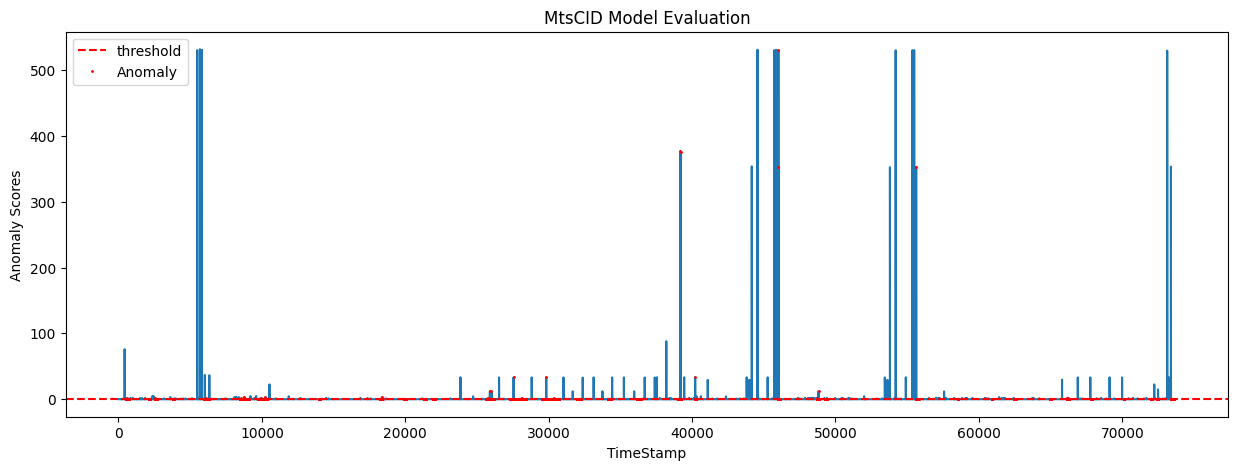

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(test_energy)
plt.axhline(y=threshold, color='r', linestyle='--', label='threshold')
anomaly_indices = np.where(gt == 1)[0]
plt.plot(np.arange(len(test_energy))[anomaly_indices], test_energy[anomaly_indices], 'r.', markersize=2,
         label='Anomaly')
plt.title(f'{MODEL} Model Evaluation')
plt.xlabel('TimeStamp')
plt.ylabel('Anomaly Scores')
plt.legend()